In [ ]:
!pip install darts

In [2]:
!pip uninstall numpy -y

Found existing installation: numpy 1.24.3
Uninstalling numpy-1.24.3:
  Successfully uninstalled numpy-1.24.3


In [ ]:
!pip install numpy==1.22

In [5]:
import pandas as pd
import numpy as np
import darts.metrics
from darts.models import NHiTSModel
from darts import TimeSeries
from darts.metrics import mape
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import plot_residuals_analysis

In [ ]:
TSLA_daily_2022 = pd.read_csv("/kaggle/input/tsla-2022-daily-charts/HistoricalData_1701558739192.csv")

In [ ]:
TSLA_daily_2022['Date'] = pd.to_datetime(TSLA_daily_2022['Date'], format='%m/%d/%Y')
TSLA_daily_2022['Close/Last'] = pd.to_numeric(TSLA_daily_2022['Close/Last'].str.replace('$', ''), errors='coerce').round(2)
TSLA_daily_2022['Open'] = pd.to_numeric(TSLA_daily_2022['Open'].str.replace('$', ''), errors='coerce').round(2)
TSLA_daily_2022['High'] = pd.to_numeric(TSLA_daily_2022['High'].str.replace('$', ''), errors='coerce').round(2)
TSLA_daily_2022['Low'] = pd.to_numeric(TSLA_daily_2022['Low'].str.replace('$', ''), errors='coerce').round(2)
TSLA_daily_2022['Volume'] = TSLA_daily_2022['Volume'].astype(int)

In [ ]:
TSLA_daily_2022.head(2)

In [ ]:
TSLA_daily_2022['volitility'] = np.log(TSLA_daily_2022['Close/Last']) - np.log(TSLA_daily_2022['Close/Last'].shift(1))
TSLA_daily_2022['realized_volitility_5'] = TSLA_daily_2022['volitility'].rolling(window=5).sum().apply(lambda x: np.sqrt(np.abs(x)))
TSLA_daily_2022['realized_volitility_10'] = TSLA_daily_2022['volitility'].rolling(window=10).sum().apply(lambda x: np.sqrt(np.abs(x)))
TSLA_daily_2022['realized_volitility_20'] = TSLA_daily_2022['volitility'].rolling(window=20).sum().apply(lambda x: np.sqrt(np.abs(x)))
TSLA_daily_2022['average_price'] = (TSLA_daily_2022['Open'] + TSLA_daily_2022['Close/Last']) / 2
TSLA_daily_2022['ema_30'] = TSLA_daily_2022['average_price'].ewm(span=30, adjust=False).mean()

In [ ]:
TSLA_daily_2022.columns

In [ ]:
TSLA_daily_2022.head(2)

In [ ]:
cols = ['Close/Last', 'Volume', 'Open', 'High', 'Low', 'volitility',
       'realized_volitility_5', 'realized_volitility_10',
       'realized_volitility_20', 'average_price', 'ema_30']

date_data = TSLA_daily_2022['Date']
numerical_data = TSLA_daily_2022[cols]
# Standardize numerical columns
scaler = StandardScaler()
numerical_data_standardized = pd.DataFrame(scaler.fit_transform(numerical_data), columns=cols)

# Concatenate the standardized numerical columns with the date column
#TSLA_daily_2022_scaled = pd.concat([date_data, numerical_data_standardized], axis=1)
TSLA_daily_2022_scaled = numerical_data_standardized

In [ ]:
TSLA_daily_2022_scaled.head(2)

In [ ]:
val_cols = ['Close/Last', 'Volume', 'Open', 'High', 'Low', 'average_price', 'ema_30']

full_cols = ['Close/Last', 'Volume', 'Open', 'High', 'Low', 'volitility',
             'realized_volitility_5', 'realized_volitility_10',
             'realized_volitility_20', 'average_price', 'ema_30']

# TSLA_ts_p = TimeSeries.from_dataframe(TSLA_daily_2022_scaled, value_cols = full_cols)

# scaler = StandardScaler()
# transformer = Scaler(scaler, global_fit = False)
# TSLA_ts = transformer.fit_transform(TSLA_ts_p)

# columns_to_scale = TSLA_daily_2022.drop('Date', axis=1)
#TSLA_ts = TimeSeries.from_dataframe(columns_to_scale, value_cols = val_cols)

# columns_to_scale = TSLA_daily_2022_scaled.drop('Date', axis=1)
# TSLA_ts = TimeSeries.from_dataframe(columns_to_scale)
TSLA_ts = TimeSeries.from_dataframe(TSLA_daily_2022, value_cols = full_cols)

In [ ]:
TSLA_ts

In [ ]:
cov = [close, volume,open_,high,low,volitility,realized_vol_5,realized_vol_10,realized_vol_20, ema]
for e in cov:
    print(e.start_time() + e.end_time())

In [ ]:
front, back = (20,None)
close = TSLA_ts['Close/Last'][front:back]
volume = TSLA_ts['Volume'][front:back]
open_ = TSLA_ts['Open'][front:back]
high = TSLA_ts['High'][front:back]
low = TSLA_ts['Low'][front:back]
volitility = TSLA_ts['volitility'][front:back]
realized_vol_5 = TSLA_ts['realized_volitility_5'][front:back]
realized_vol_10 = TSLA_ts['realized_volitility_10'][front:back]
realized_vol_20 = TSLA_ts['realized_volitility_20'][front:back]
ema = TSLA_ts['ema_30'][20:back]

cov_ts = [open_,high,low,volitility,realized_vol_5,realized_vol_10,realized_vol_20, ema]

past_cov = volume.copy()

for e in cov_ts:
    past_cov.stack(e)

model = NHiTSModel(
    input_chunk_length=5,
    output_chunk_length=6,
    num_blocks=2,
    n_epochs=50,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    }
)
model.add
model.fit([close], past_covariates= past_cov, verbose=True)

# Make predictions on the validation set

In [ ]:
pred_series = model.predict(n=2, series = close)

In [ ]:
pred_series

In [ ]:
raw_errors = model.backtest(
    series = close, start=0.6, forecast_horizon=3, metric=mape, reduction=None, verbose=True
)

In [ ]:
from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

In [ ]:
nhits_historical_forcast_1 = model.historical_forecasts(
    close, start=0.8, forecast_horizon=1, verbose=False
)
# nhits_historical_forcast_5 = model.historical_forecasts(
#     close, start=0.8, forecast_horizon=5, verbose=False
# )
# nhits_historical_forcast_10 = model.historical_forecasts(
#     close, start=0.8, forecast_horizon=10, verbose=False
# )

In [ ]:
close[60:].plot(label="data")
nhits_historical_forcast_1.plot(label="nhits_historical_forcast_1")
# nhits_historical_forcast_5.plot(label="nhits_historical_forcast_5")
# nhits_historical_forcast_10.plot(label="nhits_historical_forcast_10")
print("MAPE1 = {:.2f}%".format(mape(nhits_historical_forcast_1, close)))
# print("MAPE5 = {:.2f}%".format(mape(nhits_historical_forcast_5, close)))
# print("MAPE10 = {:.2f}%".format(mape(nhits_historical_forcast_10, close)))
print("rmse1 = {:.2f}%".format(darts.metrics.rmse(nhits_historical_forcast_1, close)))

In [ ]:
TSLA_daily_2022_v2 = pd.read_csv("/kaggle/input/true-2022-tsla/TSLA-2022-price-history.csv")
TSLA_daily_news = pd.read_csv("/kaggle/input/tsla-news-2022/Updated_Headlines2022_Sentiment_Analysis.csv")
TSLA_daily_2022_v2['Date'] = pd.to_datetime(TSLA_daily_2022_v2['Date'])

In [ ]:
TSLA_daily_2022_v2.head(2)

In [ ]:
TSLA_daily_news.head(2)

In [ ]:
TSLA_daily_news['Relevance_GPT'].unique()

In [ ]:
sentiment_mapping = {
    'Very Negative': 0,
    'Slightly Negative': 1,
    'Neutral': 2,
    'Slightly Positive': 3,
    'Very Positive': 4
}
TSLA_daily_news['Sentiment_GPT_encoded'] = TSLA_daily_news['Sentiment_GPT'].map(sentiment_mapping)

In [ ]:
relevance_mapping = {
    'Not Relevant': 0,
    'Slightly Relevant': 1,
    'Moderately Relevant': 2,
    'Very Relevant': 3
}

TSLA_daily_news['Relevance_GPT_encoded'] = TSLA_daily_news['Relevance_GPT'].map(relevance_mapping)

In [ ]:
TSLA_daily_news.head(2)

In [ ]:
TSLA_daily_news['Date'] = pd.to_datetime(TSLA_daily_news['Date'])
grouped_df = TSLA_daily_news.groupby('Date')
aggregated_df = grouped_df.agg({
    'Sentiment_GPT_encoded': 'mean',  # You can use other aggregation functions like 'sum' or 'max' depending on your preference
    'Relevance_GPT_encoded': 'mean'
}).reset_index()

In [ ]:
aggregated_df["Date"].unique()
filtered_df = aggregated_df[aggregated_df['Date'].dt.dayofweek < 5]
filtered_df["Date"].unique()
date_range_start = filtered_df['Date'].min()
date_range_end = filtered_df['Date'].max()
print(f"Date Range: {date_range_start} to {date_range_end}")

In [ ]:
TSLA_daily_2022_v2["Date"].unique()
date_range_start = TSLA_daily_2022_v2['Date'].min()
date_range_end = TSLA_daily_2022_v2['Date'].max()
print(f"Date Range: {date_range_start} to {date_range_end}")

In [ ]:
cols = ['Close/Last', 'Volume', 'Open', 'High', 'Low', 'volitility',
       'realized_volitility_5', 'realized_volitility_10',
       'realized_volitility_20', 'average_price', 'ema_30']

date_data = TSLA_daily_2022['Date']
numerical_data = TSLA_daily_2022[cols]
# Standardize numerical columns
scaler = StandardScaler()
numerical_data_standardized = pd.DataFrame(scaler.fit_transform(numerical_data), columns=cols)

# Concatenate the standardized numerical columns with the date column
#TSLA_daily_2022_scaled = pd.concat([date_data, numerical_data_standardized], axis=1)
TSLA_daily_2022_scaled = numerical_data_standardized

In [ ]:
TSLA_daily_2022_v2['Date'] = pd.to_datetime(TSLA_daily_2022_v2['Date'])
TSLA_stock_news = pd.merge(TSLA_daily_2022_v2, filtered_df, on='Date', how='inner')

In [ ]:
TSLA_stock_news

In [ ]:
TSLA_stock_news.columns

In [ ]:
TSLA_daily_news_2022_scaled.shape

In [ ]:
TSLA_daily_news_2022_scaled.columns

In [ ]:
cols_news_full = ['Close', 'Volume', 'Open', 'High', 'Low','Adj Close',
                  'Sentiment_GPT_encoded', 'Relevance_GPT_encoded']

TSLA_ts_news = TimeSeries.from_dataframe(TSLA_daily_news_2022_scaled, value_cols = cols_news_full)

In [ ]:
TSLA_ts_news

In [ ]:
front, back = (20,None)
close_news = TSLA_ts_news['Close'][front:back]
volume_news = TSLA_ts_news['Volume'][front:back]
adj_close = TSLA_ts_news['Adj Close'][front:back]
open_news = TSLA_ts_news['Open'][front:back]
high_news = TSLA_ts_news['High'][front:back]
low_news = TSLA_ts_news['Low'][front:back]
Sentiment_GPT_encoded = TSLA_ts_news['Sentiment_GPT_encoded'][front:back]
Relevance_GPT_encoded = TSLA_ts_news['Relevance_GPT_encoded'][front:back]

cov_ts = [volume_news,open_news,high_news,low_news,Sentiment_GPT_encoded,Relevance_GPT_encoded]

past_cov = volume_news.copy()

for e in cov_ts:
    past_cov.stack(e)

model = NHiTSModel(
    input_chunk_length=5,
    output_chunk_length=6,
    num_blocks=2,
    n_epochs=50,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    }
)
model.fit([close_news], past_covariates= past_cov, verbose=True)

# Make predictions on the validation set

In [ ]:
nhits_historical_forcast_1 = model.historical_forecasts(
    close, start=0.8, forecast_horizon=1, verbose=False
)
# nhits_historical_forcast_5 = model.historical_forecasts(
#     close, start=0.8, forecast_horizon=5, verbose=False
# )
# nhits_historical_forcast_10 = model.historical_forecasts(
#     close, start=0.8, forecast_horizon=10, verbose=False
# )

In [ ]:
close[60:].plot(label="data")
nhits_historical_forcast_1.plot(label="nhits_historical_forcast_1")
# nhits_historical_forcast_5.plot(label="nhits_historical_forcast_5")
# nhits_historical_forcast_10.plot(label="nhits_historical_forcast_10")
print("MAPE1 = {:.2f}%".format(mape(nhits_historical_forcast_1, close)))
# print("MAPE5 = {:.2f}%".format(mape(nhits_historical_forcast_5, close)))
# print("MAPE10 = {:.2f}%".format(mape(nhits_historical_forcast_10, close)))

pulling everything in

In [6]:
TSLA_daily_2022_v3 = pd.read_csv("/kaggle/input/true-2022-tsla/TSLA-2022-price-history.csv")
TSLA_daily_news_v2 = pd.read_csv("/kaggle/input/tsla-news-2022/Updated_Headlines2022_Sentiment_Analysis.csv")
TSLA_daily_2022_v3['Date'] = pd.to_datetime(TSLA_daily_2022_v3['Date'])

In [7]:
vix = pd.read_csv('/kaggle/input/vix-data/VIX_History.csv')
vix = vix.rename(columns={'DATE': 'Date'})
vix['Date'] = pd.to_datetime(vix['Date'])
vix['Avg_OPEN_CLOSE_vix'] = (vix['OPEN'] + vix['CLOSE']) / 2
vix_2022 = vix[vix['Date'].dt.year == 2022][['Date', 'Avg_OPEN_CLOSE_vix']]

In [8]:
vix_2022.head(2)

,Date,Avg_OPEN_CLOSE_vix
8060,2022-01-03,17.10
8061,2022-01-04,16.74


In [10]:
TSLA_daily_2022_v3['volitility'] = np.log(TSLA_daily_2022_v3['Close']) - np.log(TSLA_daily_2022_v3['Close'].shift(1))
TSLA_daily_2022_v3['realized_volitility_5'] = TSLA_daily_2022_v3['volitility'].rolling(window=5).sum().apply(lambda x: np.sqrt(np.abs(x)))
TSLA_daily_2022_v3['realized_volitility_10'] = TSLA_daily_2022_v3['volitility'].rolling(window=10).sum().apply(lambda x: np.sqrt(np.abs(x)))
TSLA_daily_2022_v3['realized_volitility_20'] = TSLA_daily_2022_v3['volitility'].rolling(window=20).sum().apply(lambda x: np.sqrt(np.abs(x)))
TSLA_daily_2022_v3['average_price'] = (TSLA_daily_2022_v3['Open'] + TSLA_daily_2022_v3['Close']) / 2
TSLA_daily_2022_v3['ema_30'] = TSLA_daily_2022_v3['average_price'].ewm(span=30, adjust=False).mean()
TSLA_daily_2022_v3['Delta'] = (TSLA_daily_2022_v3['Close']- TSLA_daily_2022_v3['Open'])


In [11]:
sentiment_mapping = {
    'Very Negative': 0,
    'Slightly Negative': 1,
    'Neutral': 2,
    'Slightly Positive': 3,
    'Very Positive': 4
}
TSLA_daily_news_v2['Sentiment_GPT_encoded'] = TSLA_daily_news_v2['Sentiment_GPT'].map(sentiment_mapping)

relevance_mapping = {
    'Not Relevant': 0,
    'Slightly Relevant': 1,
    'Moderately Relevant': 2,
    'Very Relevant': 3
}

TSLA_daily_news_v2['Relevance_GPT_encoded'] = TSLA_daily_news_v2['Relevance_GPT'].map(relevance_mapping)

TSLA_daily_news_v2['Date'] = pd.to_datetime(TSLA_daily_news_v2['Date'])
grouped_df = TSLA_daily_news_v2.groupby('Date')
aggregated_df = grouped_df.agg({
    'Sentiment_GPT_encoded': 'mean',  # You can use other aggregation functions like 'sum' or 'max' depending on your preference
    'Relevance_GPT_encoded': 'mean'
}).reset_index()

TSLA_daily_2022_v3 = pd.merge(TSLA_daily_2022_v3, aggregated_df, on='Date', how='inner')
TSLA_daily_2022_v3 = pd.merge(TSLA_daily_2022_v3, vix_2022, on='Date', how='inner')

In [12]:
TSLA_daily_2022_v3.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,volitility,realized_volitility_5,realized_volitility_10,realized_volitility_20,average_price,ema_30,Delta,Sentiment_GPT_encoded,Relevance_GPT_encoded,Avg_OPEN_CLOSE_vix
0,2022-01-03,382.583344,400.356659,378.679993,399.926666,399.926666,103931400,NaN,NaN,NaN,NaN,391.255005,391.255005,17.343322,2.25,0.375000,17.10
1,2022-01-04,396.516663,402.666656,374.350006,383.196655,383.196655,100248300,-0.042733,NaN,NaN,NaN,389.856659,391.164789,-13.320008,2.00,0.333333,16.74


In [ ]:
cols_news_full = ['Close', 'Volume', 'Open', 'High', 'Low','Adj Close', 'volitility', 'realized_volitility_5', 'realized_volitility_10',
                  'realized_volitility_20', 'ema_30','Sentiment_GPT_encoded', 'Relevance_GPT_encoded', 'Avg_OPEN_CLOSE_vix']

date_data = TSLA_daily_2022_v3['Date']
numerical_data = TSLA_daily_2022_v3[cols_news_full]
# Standardize numerical columns
scaler = StandardScaler()
numerical_data_standardized = pd.DataFrame(scaler.fit_transform(numerical_data), columns=cols_news_full)

# Concatenate the standardized numerical columns with the date column
#TSLA_daily_2022_scaled = pd.concat([date_data, numerical_data_standardized], axis=1)
TSLA_daily_news_2022_scaled_v3 = numerical_data_standardized

In [15]:
TSLA_daily_2022_v3.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume,volitility,realized_volitility_5,realized_volitility_10,realized_volitility_20,average_price,ema_30,Delta,Sentiment_GPT_encoded,Relevance_GPT_encoded,Avg_OPEN_CLOSE_vix
0,2022-01-03,382.583344,400.356659,378.679993,399.926666,399.926666,103931400,NaN,NaN,NaN,NaN,391.255005,391.255005,17.343322,2.25,0.375,17.1


In [13]:
cols_news_full = ['Close', 'Volume', 'Open', 'High', 'Low','Adj Close', 'volitility', 'realized_volitility_5', 'realized_volitility_10',
                  'realized_volitility_20', 'ema_30','Sentiment_GPT_encoded', 'Relevance_GPT_encoded', 'Avg_OPEN_CLOSE_vix']

TSLA_ts_v3 = TimeSeries.from_dataframe(TSLA_daily_2022_v3, value_cols = cols_news_full)

In [26]:
TSLA_ts_v3 = TimeSeries.from_dataframe(TSLA_daily_news_2022_scaled_v3, value_cols = cols_news_full)

In [ ]:
TSLA_ts_v3

In [22]:
from darts.models import TransformerModel

In [29]:
front, back = (20,None)
close_t = TSLA_ts_v3['Close'][front:back]
volume_t = TSLA_ts_v3['Volume'][front:back]
adj_t = TSLA_ts_v3['Adj Close'][front:back]
open_t = TSLA_ts_v3['Open'][front:back]
high_t = TSLA_ts_v3['High'][front:back]
low_t = TSLA_ts_v3['Low'][front:back]
volitility_t = TSLA_ts_v3['volitility'][front:back]
realized_vol_5_t = TSLA_ts_v3['realized_volitility_5'][front:back]
realized_vol_10_t = TSLA_ts_v3['realized_volitility_10'][front:back]
realized_vol_20_t = TSLA_ts_v3['realized_volitility_20'][front:back]
ema_t = TSLA_ts_v3['ema_30'][20:back]
Sentiment_GPT_encoded_t = TSLA_ts_v3['Sentiment_GPT_encoded'][front:back]
Relevance_GPT_encoded_t = TSLA_ts_v3['Relevance_GPT_encoded'][front:back]
vix_t = TSLA_ts_v3['Avg_OPEN_CLOSE_vix'][front:back]

In [ ]:
TSLA_ts_v3

In [23]:
# cov_ts = [volume_t,high_t,open_t,low_t, volitility_t, 
#           realized_vol_5_t, ema_t,
#           Sentiment_GPT_encoded_t,Relevance_GPT_encoded_t]
cov_ts = [volume_t,high_t,open_t,low_t, ema_t,
          Sentiment_GPT_encoded_t,Relevance_GPT_encoded_t]

past_cov = volume_t.copy()

for e in cov_ts:
    past_cov.stack(e)

model_transformer = TransformerModel(
    input_chunk_length=6,
    output_chunk_length=6,
    n_epochs=20,
    nhead = 7,
    d_model = 14,
    add_encoders={
        'transformer': Scaler(StandardScaler())
    },
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": [0],
    }
)
model_transformer.fit(close_t, past_covariates=past_cov)

/opt/conda/lib/python3.10/site-packages/torch/random.py:107: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of GPUs.  If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using.  For example, if you are using CPU only, set CUDA_VISIBLE_DEVICES= or devices=[]; if you are using GPU 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

TransformerModel(d_model=14, nhead=7, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=6, output_chunk_length=6, n_epochs=20, add_encoders={'transformer': Scaler}, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

In [ ]:
TSLA_ts_v3

In [ ]:
plot_residuals_analysis(model_transformer.residuals(close_t))

In [ ]:
transformer_historical_inital_forcast_1 = model_transformer.historical_forecasts(
    close_t, start=0.8, forecast_horizon=1, verbose=True
)
transformer_historical_inital_forcast_5 = model_transformer.historical_forecasts(
    close_t, start=0.8, forecast_horizon=5, verbose=True
)
transformer_historical_inital_forcast_10 = model_transformer.historical_forecasts(
    close_t, start=0.8, forecast_horizon=10, verbose=True
)



NameError: name 'transformer_historical_inital_forcast_1' is not defined

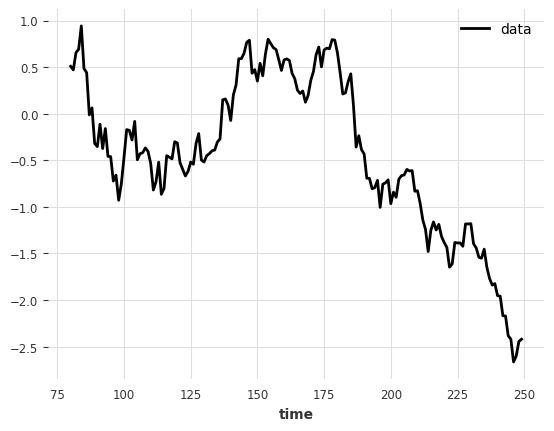

In [38]:
close_t[60:].plot(label="data")
transformer_historical_inital_forcast_1.plot(label="transformer_historical_forcast_1")
transformer_historical_inital_forcast_5.plot(label="transformer_historical_forcast_5")
transformer_historical_inital_forcast_10.plot(label="transformer_historical_forcast_10")
print("MAPE1 = {:.2f}%".format(mape(transformer_historical_inital_forcast_1, close_t)))
print("MAPE5 = {:.2f}%".format(mape(transformer_historical_inital_forcast_5, close_t)))
print("MAPE10 = {:.2f}%".format(mape(transformer_historical_inital_forcast_10, close_t)))
print("mse1 = {:.2f}%".format(darts.metrics.mse(transformer_historical_inital_forcast_1, close_t)))
print("mse5 = {:.2f}%".format(darts.metrics.mse(transformer_historical_inital_forcast_5, close_t)))
print("mse10 = {:.2f}%".format(darts.metrics.mse(transformer_historical_inital_forcast_10, close_t)))

In [ ]:
volume_t

In [17]:
from darts.models import NLinearModel
cov_ts_Dlinear = [volume_t,high_t,open_t,low_t, volitility_t, 
          realized_vol_5_t, ema_t,vix_t,adj_t,
          Sentiment_GPT_encoded_t,Relevance_GPT_encoded_t]

# cov_ts_N = [volume_t, realized_vol_5_t, ema_t, vix_t, adj_t,
#           Sentiment_GPT_encoded_t,Relevance_GPT_encoded_t]
# cov_ts_Dlinear = [volume_t,high_t,open_t,low_t, ema_t,
#           Sentiment_GPT_encoded_t,Relevance_GPT_encoded_t]

past_cov_Dlinear = volume_t.copy()

for e in cov_ts_Dlinear:
    past_cov_Dlinear.stack(e)

model_linear = NLinearModel(
    input_chunk_length=6,
    output_chunk_length=6,
    n_epochs=50,
    add_encoders={
        'transformer': Scaler(StandardScaler())
    },
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": [0],
    }
)

model_linear.fit(close_t)

/opt/conda/lib/python3.10/site-packages/torch/random.py:107: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of GPUs.  If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using.  For example, if you are using CPU only, set CUDA_VISIBLE_DEVICES= or devices=[]; if you are using GPU 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

NLinearModel(shared_weights=False, const_init=True, normalize=False, use_static_covariates=True, input_chunk_length=6, output_chunk_length=6, n_epochs=50, add_encoders={'transformer': Scaler}, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

In [ ]:
linear_historical_inital_forcast_1 = model_linear.historical_forecasts(
    close_t, start=0.8, forecast_horizon=1, verbose=True
)
linear_historical_inital_forcast_5 = model_linear.historical_forecasts(
    close_t, start=0.8, forecast_horizon=5, verbose=True
)
linear_historical_inital_forcast_10 = model_linear.historical_forecasts(
    close_t, start=0.8, forecast_horizon=10, verbose=True
)

In [ ]:
plot_residuals_analysis(model_linear.residuals(close_t))

MAPE1 = 5.79%
MAPE5 = 9.82%
MAPE10 = 12.63%


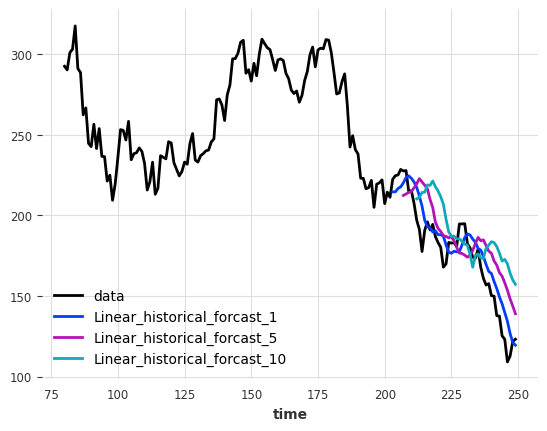

In [19]:
close_t[60:].plot(label="data")
linear_historical_inital_forcast_1.plot(label="Linear_historical_forcast_1")
linear_historical_inital_forcast_5.plot(label="Linear_historical_forcast_5")
linear_historical_inital_forcast_10.plot(label="Linear_historical_forcast_10")
print("MAPE1 = {:.2f}%".format(mape(linear_historical_inital_forcast_1, close_t)))
print("MAPE5 = {:.2f}%".format(mape(linear_historical_inital_forcast_5, close_t)))
print("MAPE10 = {:.2f}%".format(mape(linear_historical_inital_forcast_10, close_t)))
# print("mse1 = {:.2f}%".format(darts.metrics.mse(linear_historical_inital_forcast_1, close_t)))
# print("mse5 = {:.2f}%".format(darts.metrics.mse(linear_historical_inital_forcast_5, close_t)))
# print("mse10 = {:.2f}%".format(darts.metrics.mse(linear_historical_inital_forcast_10, close_t)))

In [ ]:
volume_t

In [76]:
# cov_ts_N = [volume_t,high_t,open_t,low_t, volitility_t, 
#           realized_vol_5_t, ema_t,vix_t,adj_t,
#           Sentiment_GPT_encoded_t,Relevance_GPT_encoded_t]
cov_ts_N = [volume_t,high_t,open_t,low_t, ema_t]
#           Sentiment_GPT_encoded_t,Relevance_GPT_encoded_t]
# cov_ts_N = [volume_t,high_t,open_t,low_t, ema_t,adj_t]
past_cov_N = volume_t.copy()

for e in cov_ts_N:
    past_cov_N.stack(e)

model_N = NHiTSModel(
    input_chunk_length=5,
    output_chunk_length=6,
    num_blocks=2,
    n_epochs=50,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    }
)
model_N.fit([close_t], past_covariates= past_cov_N, verbose=True)

Training: |          | 0/? [00:00<?, ?it/s]

NHiTSModel(num_stacks=3, num_blocks=2, num_layers=2, layer_widths=512, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1, activation=ReLU, MaxPool1d=True, input_chunk_length=5, output_chunk_length=6, n_epochs=50, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

In [ ]:
train_loss = model.trainer.train_loss

# Plot the training loss over time
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

In [ ]:
nhits_historical_forcast_1 = model_N.historical_forecasts(
    close_t, start=0.8, forecast_horizon=1, verbose=True
)
nhits_historical_forcast_5 = model_N.historical_forecasts(
    close_t, start=0.8, forecast_horizon=5, verbose=True
)
nhits_historical_forcast_10 = model_N.historical_forecasts(
    close_t, start=0.8, forecast_horizon=10, verbose=True
)

  0%|          | 0/47 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
plot_residuals_analysis(model_N.residuals(close_t))

MAPE1 = 3.79%
MAPE5 = 8.94%
MAPE10 = 11.10%


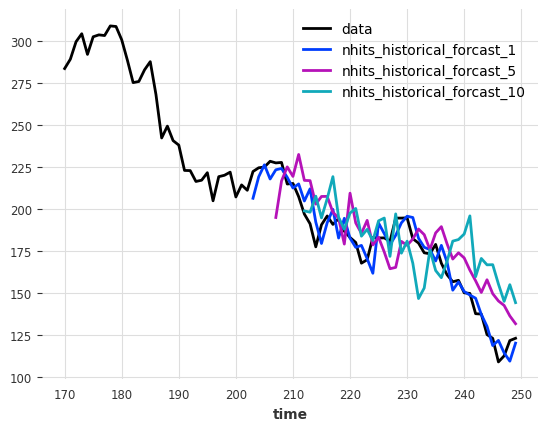

In [75]:
close_t[150:].plot(label="data")
nhits_historical_forcast_1.plot(label="nhits_historical_forcast_1")
nhits_historical_forcast_5.plot(label="nhits_historical_forcast_5")
nhits_historical_forcast_10.plot(label="nhits_historical_forcast_10")
print("MAPE1 = {:.2f}%".format(mape(nhits_historical_forcast_1, close_t)))
print("MAPE5 = {:.2f}%".format(mape(nhits_historical_forcast_5, close_t)))
print("MAPE10 = {:.2f}%".format(mape(nhits_historical_forcast_10, close_t)))

In [35]:
from darts.models import RNNModel
cov_ts_Dlinear = [volume_t,high_t,open_t,low_t, volitility_t, 
          realized_vol_5_t, ema_t,vix_t,adj_t,
          Sentiment_GPT_encoded_t,Relevance_GPT_encoded_t]

# cov_ts_N = [volume_t, realized_vol_5_t, ema_t, vix_t, adj_t,
#           Sentiment_GPT_encoded_t,Relevance_GPT_encoded_t]
# cov_ts_Dlinear = [volume_t,high_t,open_t,low_t, ema_t,
#           Sentiment_GPT_encoded_t,Relevance_GPT_encoded_t]

past_cov_Dlinear = volume_t.copy()

for e in cov_ts_Dlinear:
    past_cov_Dlinear.stack(e)

model_lstm = RNNModel(
    model="LSTM",
    n_rnn_layers = 4,
    input_chunk_length=6,
    output_chunk_length=6,
    n_epochs=40,
    add_encoders={
        'transformer': Scaler(StandardScaler())
    },
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": [0],
    }
)

model_lstm.fit(close_t)

Training: |          | 0/? [00:00<?, ?it/s]

RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=4, dropout=0.0, training_length=24, input_chunk_length=6, output_chunk_length=6, n_epochs=40, add_encoders={'transformer': Scaler}, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

In [ ]:
nhits_historical_forcast_1 = model_lstm.historical_forecasts(
    close_t, start=0.8, forecast_horizon=1, verbose=True
)
nhits_historical_forcast_5 = model_lstm.historical_forecasts(
    close_t, start=0.8, forecast_horizon=5, verbose=True
)
nhits_historical_forcast_10 = model_lstm.historical_forecasts(
    close_t, start=0.8, forecast_horizon=10, verbose=True
)

MAPE1 = 26.83%
MAPE5 = 52.27%
MAPE10 = 84.43%


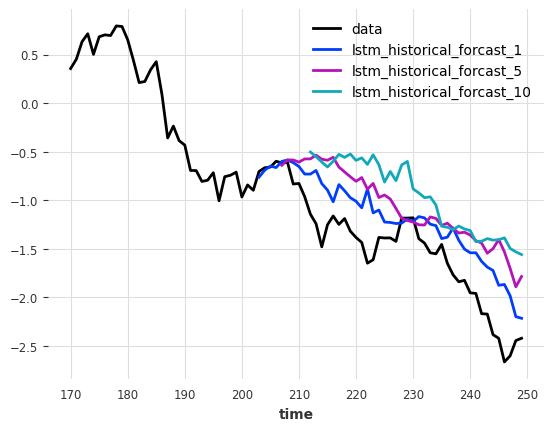

In [37]:
close_t[150:].plot(label="data")
nhits_historical_forcast_1.plot(label="lstm_historical_forcast_1")
nhits_historical_forcast_5.plot(label="lstm_historical_forcast_5")
nhits_historical_forcast_10.plot(label="lstm_historical_forcast_10")
print("MAPE1 = {:.2f}%".format(mape(nhits_historical_forcast_1, close_t)))
print("MAPE5 = {:.2f}%".format(mape(nhits_historical_forcast_5, close_t)))
print("MAPE10 = {:.2f}%".format(mape(nhits_historical_forcast_10, close_t)))